In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from matplotlib.gridspec import GridSpec
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'Helvetica'
def rgb_to_hex(r, g, b):
    r, g, b = int(r), int(g), int(b)
    return '#' + hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
color_list = [rgb_to_hex(237,74,184),rgb_to_hex(158,95,253),rgb_to_hex(255,206,81),rgb_to_hex(119,200,236),rgb_to_hex(24,218,210),rgb_to_hex(111,237,155),rgb_to_hex(102,0,51),rgb_to_hex(0,0,0),rgb_to_hex(211,196,147),rgb_to_hex(186,159,72),rgb_to_hex(89,80,65),rgb_to_hex(231,85,0),rgb_to_hex(0,138,148),rgb_to_hex(223,105,98)]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
mark=np.array(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X','o', 'v', '^', '<', '>', '8', 's', 'p', ])
color_list = color_list*2


In [2]:
def E(data_, h_pd=None, a=None, b=None):
	if isinstance(h_pd, pd.DataFrame): 
		eta = h_pd['h'] / data_['A']
	else: 
		eta = data_['h'] / data_['A']
	if a is None: 
		a, b = 0, 1

	E = pd.Series(0, index=data_.index)  # 각 row별로 저장할 E를 Series로 초기화

	t = [1,2,3,4,5]
	age = ['40_49', '50_59', '60_69', '70_79', '80_']

	for i in range(5):
		phi_t = np.exp(-eta / data_['eta_tilde' + age[i]])
		N_t = data_['RN' + age[i]] * data_['N']
		E += (a * t[i] + b) * N_t * phi_t  # row-wise 연산

	return E  # 각 row별 E 값이 담긴 Series 반환

def E_a(data_, h_pd=None, a=None, b=None):
	if isinstance(h_pd, pd.DataFrame): 
		eta = h_pd['h'] / data_['A']
	else: 
		eta = data_['h'] / data_['A']
	if a is None: 
		a, b = 0, 1

	E = pd.Series(0, index=data_.index)  # 각 row별로 저장할 E를 Series로 초기화

	t = [1,2,3,4,5]
	age = ['40_49', '50_59', '60_69', '70_79', '80_']
	E_list = []
	for i in range(5):
		phi_t = np.exp(-eta / data_['eta_tilde' + age[i]])
		N_t = data_['RN' + age[i]] * data_['N']
		E_list.append((a * t[i] + b) * N_t * phi_t)  # row-wise 연산

	return E_list  # 각 row별 E 값이 담긴 Series 반환

def b(data_, a):
	atNp, E_0 = 0,0
	eta = data_['h']/data_['A']
	t = [1,2,3,4,5]
	age = ['40_49', '50_59', '60_69', '70_79', '80_']
	for i in range(5): 
		E_0 += sum(data_['RD'+age[i]]*data_['D'])
		phi_t = np.exp(-eta/data_['eta_tilde'+age[i]])
		N_t = data_['RN'+age[i]]*data_['N']
		atNp += sum( a*t[i]*N_t*phi_t)
	return (E_0-atNp)/E_0 # b

def find_min_a(data):
	save_path='/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/at_b_tau12345/opt_E_h_a2_1/'
	ai=0
	E_list=[]
	E_a_min = []
	for i in range(31):
		E_ = np.load(save_path+str(year)+'_age_E_a_'+str(ai)+'.npy')
		E_list.append(E_[-1])
		ai+=1
	a_i=0
	for a in np.linspace(-2, 1, 31):
		if a*5+b(data,a) > 0: 
			E_a_min.append(E_list[a_i])
			break
		a_i+=1
	return a_i

In [3]:
year=2022
path = '/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/data_over40/'+str(year)+'_40.txt'
data = pd.read_csv(path,sep=',')
a_min_i = find_min_a(data)
a_max_i = 23
h_0_opt = pd.read_csv('/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/at_b_tau12345/opt_E_h_a2_1/'+str(year)+'MC_age_h_opt_a_20.csv')
h_min_opt = pd.read_csv('/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/at_b_tau12345/opt_E_h_a2_1/'+str(year)+'MC_age_h_opt_a_'+str(a_min_i)+'.csv')
h_max_opt = pd.read_csv('/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/at_b_tau12345/opt_E_h_a2_1/'+str(year)+'MC_age_h_opt_a_'+str(a_max_i)+'.csv')
y_0 = h_0_opt['h']/data['h']
y_min = h_min_opt['h']/data['h']
a_min=np.linspace(-2,1,31)[a_min_i]
a_max=np.linspace(-2,1,31)[a_max_i]
cols = data.columns[10:15]

In [4]:
# 1. 필요한 컬럼 정의
cols = data.columns[10:15]

# 2. 계산
N_age = data[cols].multiply(data['N'], axis=0)
rho_age = N_age.divide(data['A'], axis=0)
tilde_eta_age = data[data.columns[24:24+len(cols)]]

# 3. 위치기반으로 element-wise 연산 → 다시 DataFrame으로 되살림
rho_tilde_eta_age = pd.DataFrame(
    rho_age.values / tilde_eta_age.values,
    columns=cols,
    index=data.index
)

In [5]:
delta_H_min = h_min_opt - h_0_opt
b_amin = b(data, a=a_min)
b_a0 = b(data, a=0) 
delta_E_min = E(data, h_pd = h_min_opt, a = a_min, b=b_amin) - E(data, h_pd = h_0_opt, a=0, b=b_a0)
delta_E_age_min = np.array(E_a(data, h_pd = h_min_opt, a = a_min, b=b_amin))- np.array(E_a(data, h_pd = h_0_opt, a=0, b=b_a0))

delta_H_max = h_max_opt - h_0_opt
b_amax = b(data, a=a_max)
delta_E_max = E(data, h_pd = h_max_opt, a = a_max, b=b_amax) - E(data, h_pd = h_0_opt, a=0, b=b_a0)
delta_E_age_max = np.array(E_a(data, h_pd = h_max_opt, a = a_max, b=b_amax))- np.array(E_a(data, h_pd = h_0_opt, a=0, b=b_a0))

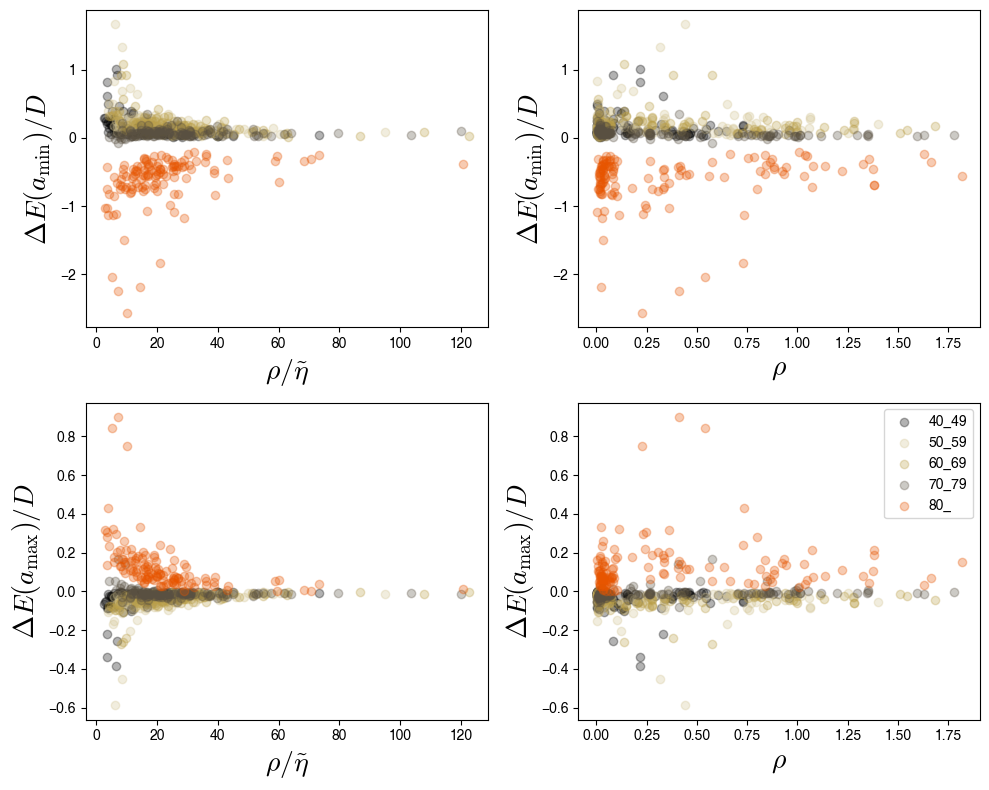

In [6]:
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,2)

x1 = rho_tilde_eta_age
x2 = rho_age
y_amin = delta_E_age_min/data['D'].values
y_amax = delta_E_age_max/data['D'].values

ax = fig.add_subplot(gs[0,0])
for i in range(5):
    ax.scatter(x1['RN' + cols[i][2:]], y_amin[i], c=color_list[i+7], alpha=0.3)
    ax.set_xlabel(r'$\rho/\tilde\eta$',size=20)
    ax.set_ylabel(r'$\Delta E(a_\mathrm{min})/D$',size=20)

ax = fig.add_subplot(gs[0,1])
for i in range(5):
    ax.scatter(x2['RN' + cols[i][2:]], y_amin[i], c=color_list[i+7], alpha=0.3)
    ax.set_xlabel(r'$\rho$',size=20)
    ax.set_ylabel(r'$\Delta E(a_\mathrm{min})/D$',size=20)

ax = fig.add_subplot(gs[1,0])
for i in range(5):
    ax.scatter(x1['RN' + cols[i][2:]], y_amax[i], c=color_list[i+7], alpha=0.3)
    ax.set_xlabel(r'$\rho/\tilde\eta$',size=20)
    ax.set_ylabel(r'$\Delta E(a_\mathrm{max})/D$',size=20)

ax = fig.add_subplot(gs[1,1])
for i in range(5):
    ax.scatter(x2['RN' + cols[i][2:]], y_amax[i], c=color_list[i+7], label=cols[i][2:], alpha=0.3)
    ax.set_xlabel(r'$\rho$',size=20)
    ax.set_ylabel(r'$\Delta E(a_\mathrm{max})/D$',size=20)
    ax.legend()
plt.tight_layout()
plt.show()

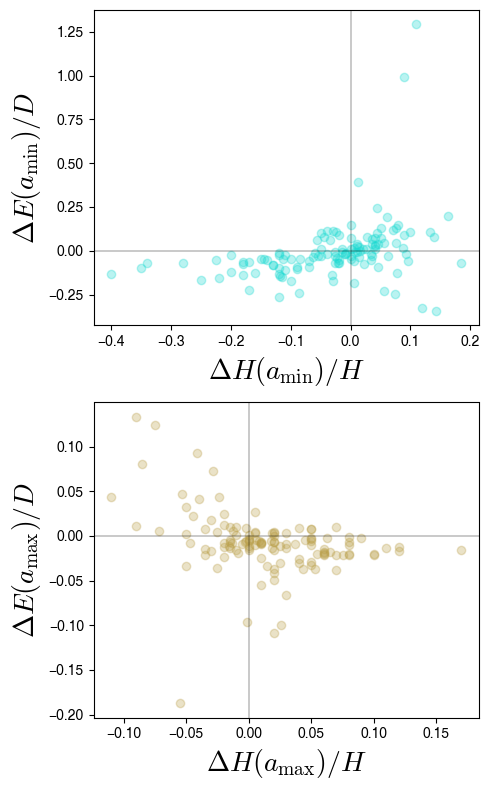

In [7]:
fig = plt.figure(figsize=[5,8])
gs = GridSpec(2,1)

ax = fig.add_subplot(gs[0,0])
ax.set_xlabel(r'$\Delta H(a_\mathrm{min}) / H$',size=20)
ax.set_ylabel(r'$\Delta E(a_\mathrm{min})/D$',size=20)
ax.axhline(y=0, color='black', linewidth=0.3)  # y축 기준선
ax.axvline(x=0, color='black', linewidth=0.3)  # x축 기준선
ax.scatter(delta_H_min['h']/data['h'], delta_E_min/data['D'], alpha=0.3, c=color_list[4])

ax = fig.add_subplot(gs[1,0])
ax.set_xlabel(r'$\Delta H(a_\mathrm{max}) / H$',size=20)
ax.set_ylabel(r'$\Delta E(a_\mathrm{max})/D$',size=20)
ax.axhline(y=0, color='black', linewidth=0.3)  # y축 기준선
ax.axvline(x=0, color='black', linewidth=0.3)  # x축 기준선
ax.scatter(delta_H_max['h']/data['h'], delta_E_max/data['D'], alpha=0.3, c=color_list[9])

plt.tight_layout()
plt.show()

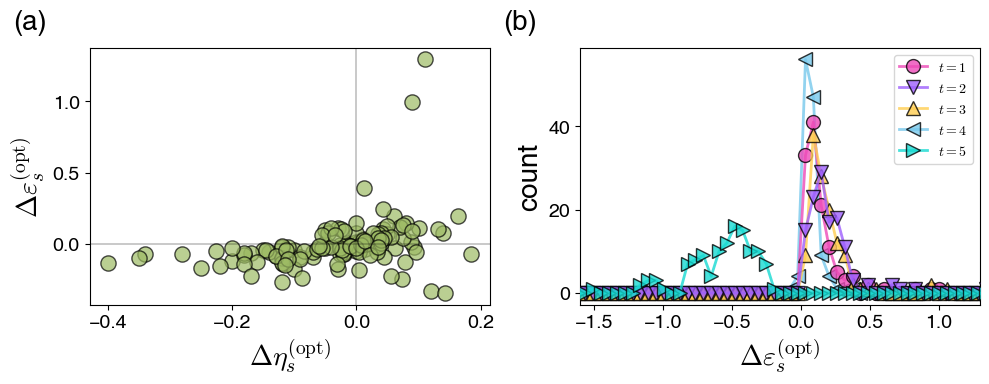

In [ ]:
title_pos=[-0.15, 1.1]
title_size = 20
title_list = ['a', 'b', 'c', 'd', 'e','f','g','h','i']

fig = plt.figure(figsize=[10,4])
gs = GridSpec(1,2)

ax = fig.add_subplot(gs[0,0])
ax.set_xlabel(r'$\Delta\eta^\mathrm{(opt)}_s$', size=20)
ax.set_ylabel(r'$\Delta\varepsilon^\mathrm{(opt)}_s$', size=20)
ax.axhline(y=0, color='black', linewidth=0.3)  # y축 기준선
ax.axvline(x=0, color='black', linewidth=0.3)  # x축 기준선
ax.scatter(delta_H_min['h']/data['h'], delta_E_min/data['D'], alpha=0.7, ec='k', s=120, c="#9DBB64")
ax.tick_params(axis='both', labelsize=14)
ax.text(title_pos[0], title_pos[1], '('+title_list[0]+')', fontsize=title_size,  ha='center', va='center',transform=ax.transAxes)

t_list = ['$t=1$', '$t=2$', '$t=3$', '$t=4$', '$t=5$']
z_order = [2,4,3,1,5]
ax1 = fig.add_subplot(gs[0,1])
bins = np.linspace(-2.5, 2.0, 80)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for i in range(5):
    y = y_amin[i]
    counts, _ = np.histogram(y, bins=bins)
    ax1.plot(bin_centers, counts, 
             label=t_list[i], 
             linewidth=2,
             marker=mark[i],
             mec = 'k',
             ms=10,
             color=color_list[i],
             zorder=z_order[i],
             alpha=0.8)
ax1.set_xlim(-1.6, 1.3)
ax1.set_xlabel(r'$\Delta\varepsilon^\mathrm{(opt)}_s$', size=20)
ax1.set_ylabel('count', size=20)
ax1.legend()
ax1.tick_params(axis='both', labelsize=14)
ax1.text(title_pos[0], title_pos[1], '('+title_list[1]+')', fontsize=title_size,  ha='center', va='center',transform=ax1.transAxes)

plt.tight_layout()
# plt.savefig('/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/figure/fig5.pdf',transparent=True,format='pdf')
plt.show()

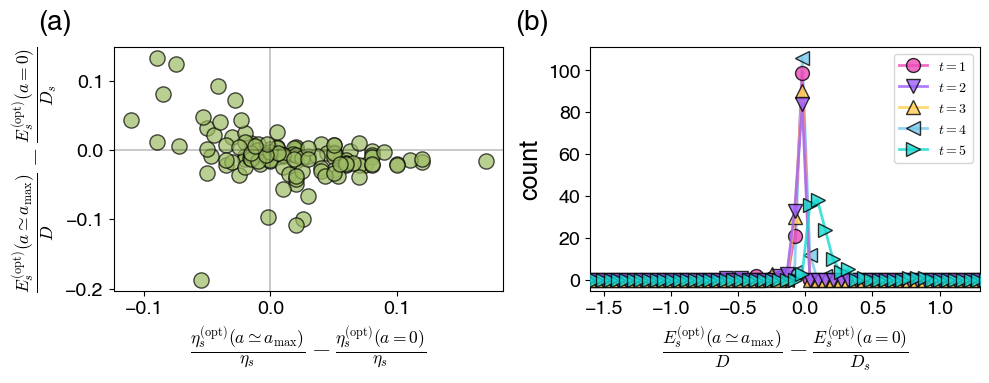

In [11]:
title_pos=[-0.15, 1.1]
title_size = 20
title_list = ['a', 'b', 'c', 'd', 'e','f','g','h','i']

fig = plt.figure(figsize=[10,4])
gs = GridSpec(1,2)

ax = fig.add_subplot(gs[0,0])
ax.set_xlabel(r'$\frac{\eta_s^{\rm (opt)}(a\simeq a_{\rm max})}{\eta_s}-\frac{\eta_s^{\rm (opt)}(a=0)}{\eta_s}$', size=18)
ax.set_ylabel(r'$\frac{E_s^{\rm (opt)}(a\simeq a_{\rm max})}{D}-\frac{E_s^{\rm (opt)}(a=0)}{D_s}$', size=18)
ax.axhline(y=0, color='black', linewidth=0.3)  # y축 기준선
ax.axvline(x=0, color='black', linewidth=0.3)  # x축 기준선
ax.scatter(delta_H_max['h']/data['h'], delta_E_max/data['D'], alpha=0.7, ec='k', s=120, c="#9DBB64")
ax.tick_params(axis='both', labelsize=14)
ax.text(title_pos[0], title_pos[1], '('+title_list[0]+')', fontsize=title_size,  ha='center', va='center',transform=ax.transAxes)

t_list = ['$t=1$', '$t=2$', '$t=3$', '$t=4$', '$t=5$']
z_order = [2,4,3,1,5]
ax1 = fig.add_subplot(gs[0,1])
bins = np.linspace(-2.5, 2.0, 80)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for i in range(5):
    y = y_amax[i]
    counts, _ = np.histogram(y, bins=bins)
    ax1.plot(bin_centers, counts, 
             label=t_list[i], 
             linewidth=2,
             marker=mark[i],
             mec = 'k',
             ms=10,
             color=color_list[i],
             zorder=z_order[i],
             alpha=0.8)
ax1.set_xlim(-1.6, 1.3)
ax1.set_xlabel(r'$\frac{E_s^{\rm (opt)}(a\simeq a_{\rm max})}{D}-\frac{E_s^{\rm (opt)}(a=0)}{D_s}$', size=18)
ax1.set_ylabel('count', size=18)
ax1.legend()
ax1.tick_params(axis='both', labelsize=14)
ax1.text(title_pos[0], title_pos[1], '('+title_list[1]+')', fontsize=title_size,  ha='center', va='center',transform=ax1.transAxes)

plt.tight_layout()
# plt.savefig('/home/users/YongsungKwon/workplace/Yongpyter/Tuberculosis_hospital_optimization/data_result/figure/fig_sm_4.pdf',transparent=True,format='pdf')
plt.show()

In [68]:
df_min = pd.DataFrame({
    'dE': delta_E_min,
    'dH': delta_H_min['h']
})

df_clean = df_min.dropna()
q1_min = df_clean[(df_clean['dE'] > 0) & (df_clean['dH'] > 0)]
q2_min = df_clean[(df_clean['dE'] > 0) & (df_clean['dH'] < 0)]
q3_min = df_clean[(df_clean['dE'] < 0) & (df_clean['dH'] < 0)]
q4_min = df_clean[(df_clean['dE'] < 0) & (df_clean['dH'] > 0)]

df_max = pd.DataFrame({
    'dE': delta_E_max,
    'dH': delta_H_max['h']
})

df_clean = df_max.dropna()
q1_max = df_clean[(df_clean['dE'] > 0) & (df_clean['dH'] > 0)]
q2_max = df_clean[(df_clean['dE'] > 0) & (df_clean['dH'] < 0)]
q3_max = df_clean[(df_clean['dE'] < 0) & (df_clean['dH'] < 0)]
q4_max = df_clean[(df_clean['dE'] < 0) & (df_clean['dH'] > 0)]

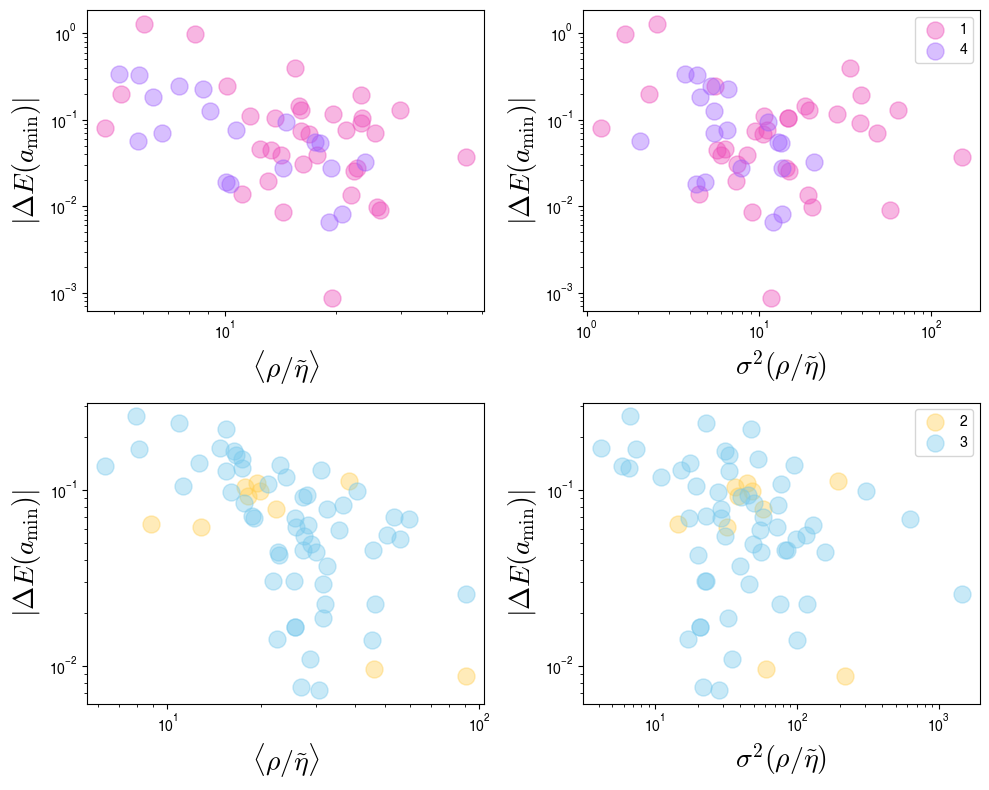

In [69]:
fig = plt.figure(figsize=[10,8])
gs=GridSpec(2,2)

ax=fig.add_subplot(gs[0,0])
x = np.mean(rho_tilde_eta_age,axis=1)

colors=color_list
c=0
for q in [q1_min, q4_min]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_min/data['D'])
    y_q = y[q_idx]
    # print(f"Color: {colors[c]}, len(x_q): {len(x_q)}, len(y_q): {len(y_q)}")
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4)
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0,0.15)
ax.set_xlabel(r'$\langle\rho/{\tilde\eta}\rangle$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{min})|$',size=20)

ax=fig.add_subplot(gs[0,1])
x = np.var(rho_tilde_eta_age,axis=1)

c=0
labels=[1,4,2,3]
for q in [q1_min, q4_min]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_min/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4,label=str(labels[c]))
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0,0.15)
ax.set_xlabel(r'$\sigma^2(\rho/{\tilde\eta})$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{min})|$',size=20)
ax.legend()

ax=fig.add_subplot(gs[1,0])
x = np.mean(rho_tilde_eta_age,axis=1)

for q in [q2_min, q3_min]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_min/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4)
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-0.2,0)
ax.set_xlabel(r'$\langle\rho/{\tilde\eta}\rangle$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{min})|$',size=20)

ax=fig.add_subplot(gs[1,1])
x = np.var(rho_tilde_eta_age,axis=1)
c=2
for q in [q2_min, q3_min]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_min/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4,label=str(labels[c]))
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-0.2,0)
ax.set_xlabel(r'$\sigma^2(\rho/{\tilde\eta})$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{min})|$',size=20)
ax.legend()

plt.tight_layout()
plt.show()

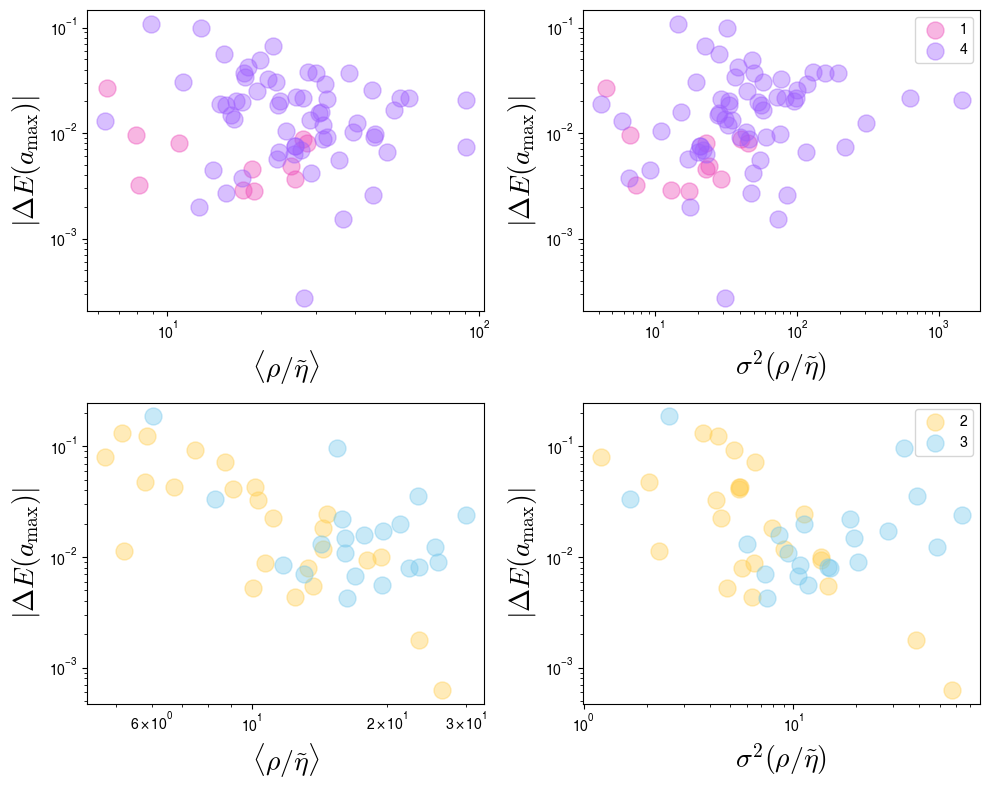

In [70]:
fig = plt.figure(figsize=[10,8])
gs=GridSpec(2,2)

ax=fig.add_subplot(gs[0,0])
x = np.mean(rho_tilde_eta_age,axis=1)

colors=color_list
c=0
for q in [q1_max, q4_max]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_max/data['D'])
    y_q = y[q_idx]
    # print(f"Color: {colors[c]}, len(x_q): {len(x_q)}, len(y_q): {len(y_q)}")
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4)
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0,0.15)
ax.set_xlabel(r'$\langle\rho/{\tilde\eta}\rangle$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{max})|$',size=20)

ax=fig.add_subplot(gs[0,1])
x = np.var(rho_tilde_eta_age,axis=1)

c=0
labels=[1,4,2,3]
for q in [q1_max, q4_max]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_max/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4,label=str(labels[c]))
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0,0.15)
ax.set_xlabel(r'$\sigma^2(\rho/{\tilde\eta})$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{max})|$',size=20)
ax.legend()

ax=fig.add_subplot(gs[1,0])
x = np.mean(rho_tilde_eta_age,axis=1)

for q in [q2_max, q3_max]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_max/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4)
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-0.2,0)
ax.set_xlabel(r'$\langle\rho/{\tilde\eta}\rangle$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{max})|$',size=20)

ax=fig.add_subplot(gs[1,1])
x = np.var(rho_tilde_eta_age,axis=1)
c=2
for q in [q2_max, q3_max]:
    x_q = x.loc[q.index]
    q_idx = q.index.to_list()
    y = np.abs(delta_E_max/data['D'])
    y_q = y[q_idx]
    ax.scatter(x_q, y_q, s=150,c = colors[c], alpha=0.4,label=str(labels[c]))
    c+=1
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-0.2,0)
ax.set_xlabel(r'$\sigma^2(\rho/{\tilde\eta})$',size=20)
ax.set_ylabel(r'$|\Delta E(a_\mathrm{max})|$',size=20)
ax.legend()

plt.tight_layout()
plt.show()

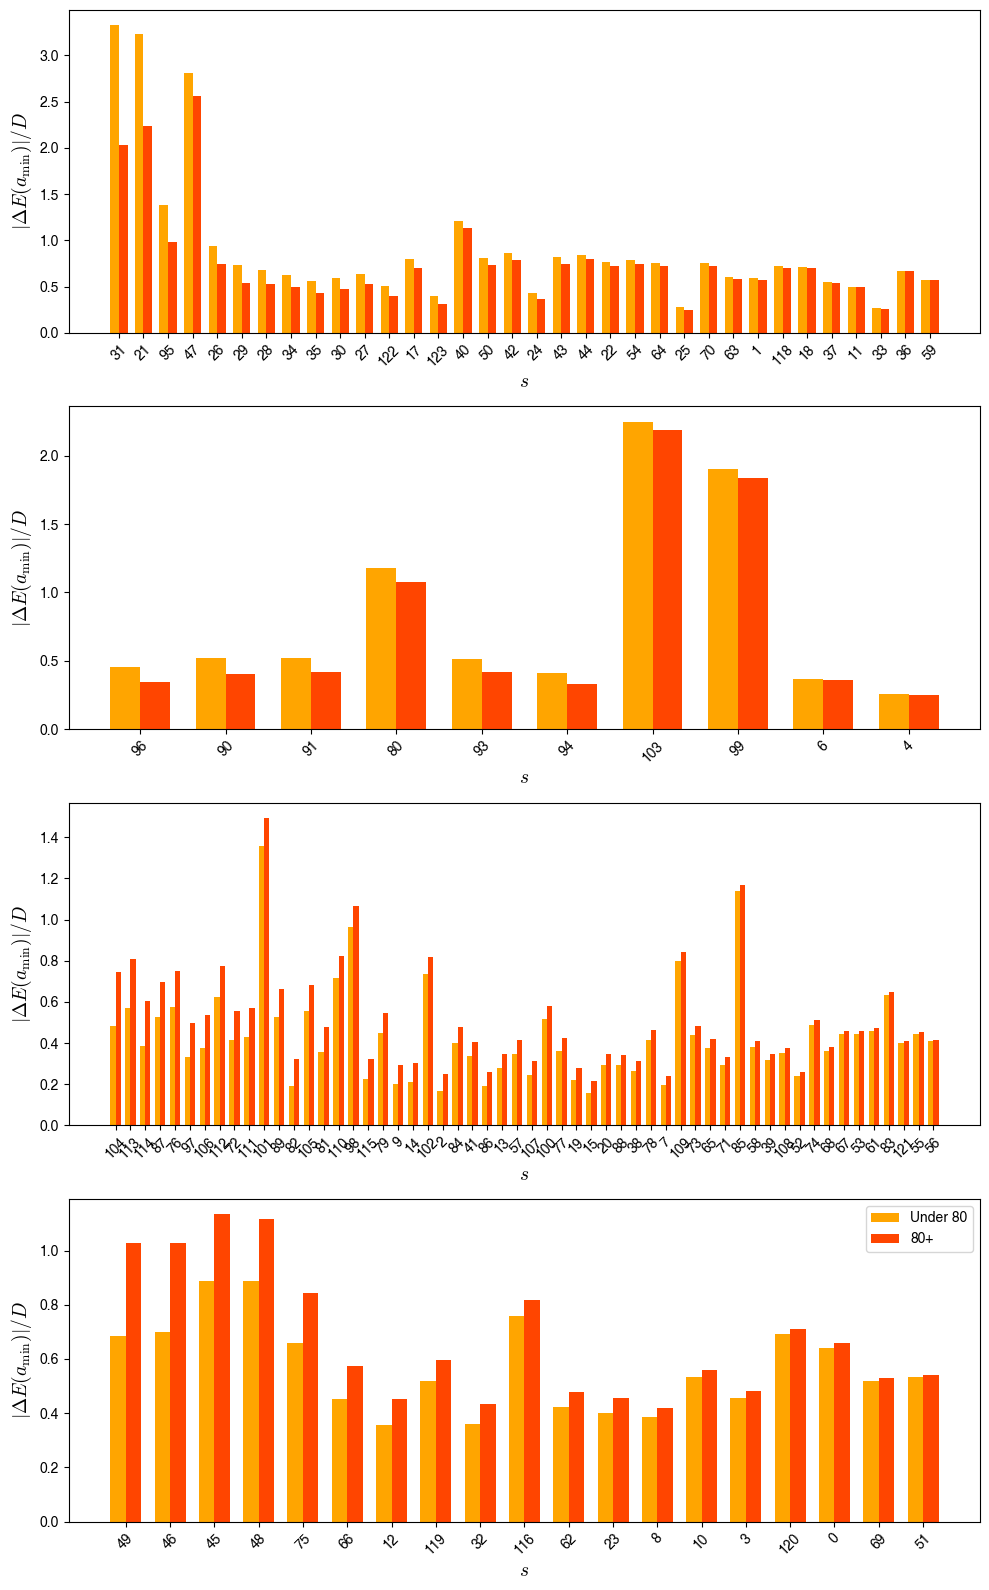

In [71]:
# ΔE 계산
sum_E_under80_min = np.sum(delta_E_age_min[:4, :], axis=0)/data['D'].values  # 80세 미만
E_80_min = delta_E_age_min[4]/data['D'].values                               # 80세 이상
qn=[q1_min,q2_min,q3_min,q4_min]
fig = plt.figure(figsize=(10, 16))
gs=GridSpec(4,1)
for i in range(4):
# q1 인덱스만 추출
    q = qn[i]
    q_index = q.index.to_list()

    # 절대값 취하기
    sum_E_under80_q = np.abs(sum_E_under80_min[q_index])
    E_80_q = np.abs(E_80_min[q_index])

    # 차이의 절대값 기준 정렬
    diff_q = np.abs(E_80_q - sum_E_under80_q)
    sorted_idx = np.argsort(-diff_q)
    sorted_q_index = [q_index[i] for i in sorted_idx]

    # 정렬된 데이터 추출
    under80_sorted = sum_E_under80_min[sorted_q_index]
    E80_sorted = E_80_min[sorted_q_index]


    x = np.arange(len(sorted_q_index))
    width = 0.35

    ax=fig.add_subplot(gs[i])
    ax.bar(x - width/2, np.abs(under80_sorted), width, label='Under 80', color='orange')
    ax.bar(x + width/2, np.abs(E80_sorted), width, label='80+', color='orangered')
    ax.set_xticks(x, sorted_q_index, rotation=45)
    # ax.set_yscale('log')
    ax.set_xlabel(r'$s$', fontsize=14)
    ax.set_ylabel(r'$|\Delta E(a_\mathrm{min})|/D$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


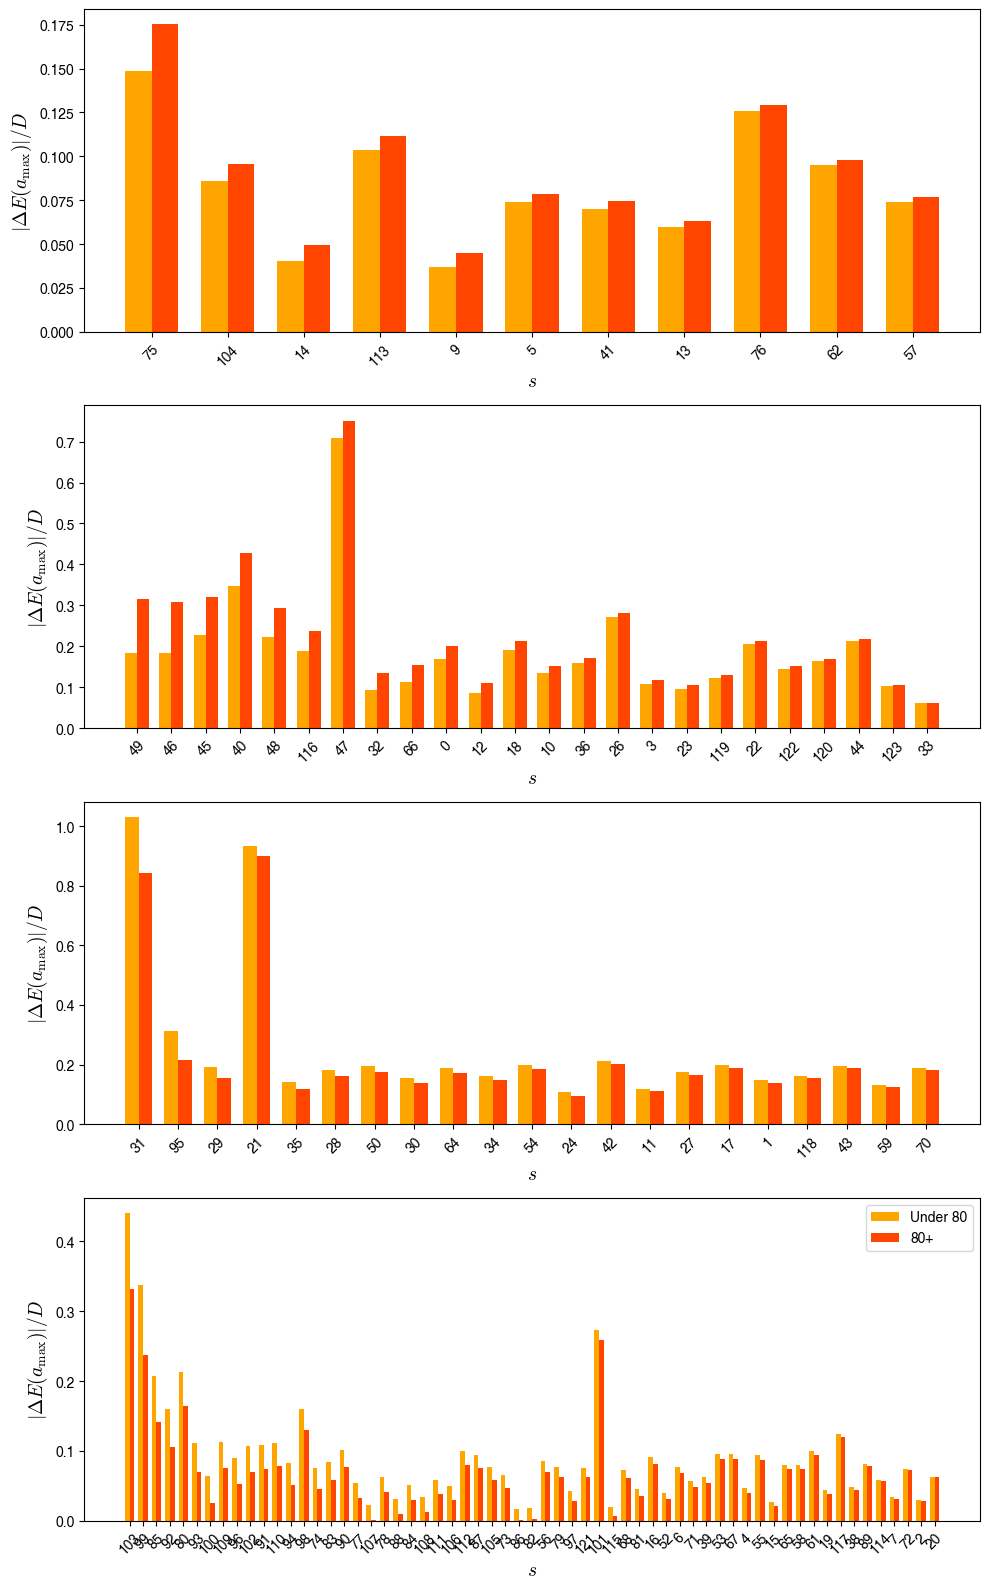

In [72]:
# ΔE 계산
sum_E_under80_max = np.sum(delta_E_age_max[:4, :], axis=0)/data['D'].values  # 80세 미만
E_80_max= delta_E_age_max[4]/data['D'].values                               # 80세 이상
qn=[q1_max,q2_max,q3_max,q4_max]
fig = plt.figure(figsize=(10, 16))
gs=GridSpec(4,1)
for i in range(4):
# q1 인덱스만 추출
    q = qn[i]
    q_index = q.index.to_list()

    # 절대값 취하기
    sum_E_under80_q = np.abs(sum_E_under80_max[q_index])
    E_80_q = np.abs(E_80_max[q_index])

    # 차이의 절대값 기준 정렬
    diff_q = np.abs(E_80_q - sum_E_under80_q)
    sorted_idx = np.argsort(-diff_q)
    sorted_q_index = [q_index[i] for i in sorted_idx]

    # 정렬된 데이터 추출
    under80_sorted = sum_E_under80_max[sorted_q_index]
    E80_sorted = E_80_max[sorted_q_index]


    x = np.arange(len(sorted_q_index))
    width = 0.35

    ax=fig.add_subplot(gs[i])
    ax.bar(x - width/2, np.abs(under80_sorted), width, label='Under 80', color='orange')
    ax.bar(x + width/2, np.abs(E80_sorted), width, label='80+', color='orangered')
    ax.set_xticks(x, sorted_q_index, rotation=45)
    # ax.set_yscale('log')
    ax.set_xlabel(r'$s$', fontsize=14)
    ax.set_ylabel(r'$|\Delta E(a_\mathrm{max})|/D$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
